Introdução


---


Agora que você pode selecionar dados brutos, está pronto para aprender como agrupar seus dados e contar coisas dentro desses grupos. Isso pode ajudá-lo a responder perguntas como:

Quantos de cada tipo de fruta nossa loja já vendeu?
Quantas espécies de animais o consultório veterinário tratou?
Para fazer isso, você aprenderá sobre três novas técnicas: GROUP BY, HAVING e COUNT(). Mais uma vez, usaremos esta tabela inventada de informações sobre animais de estimação.
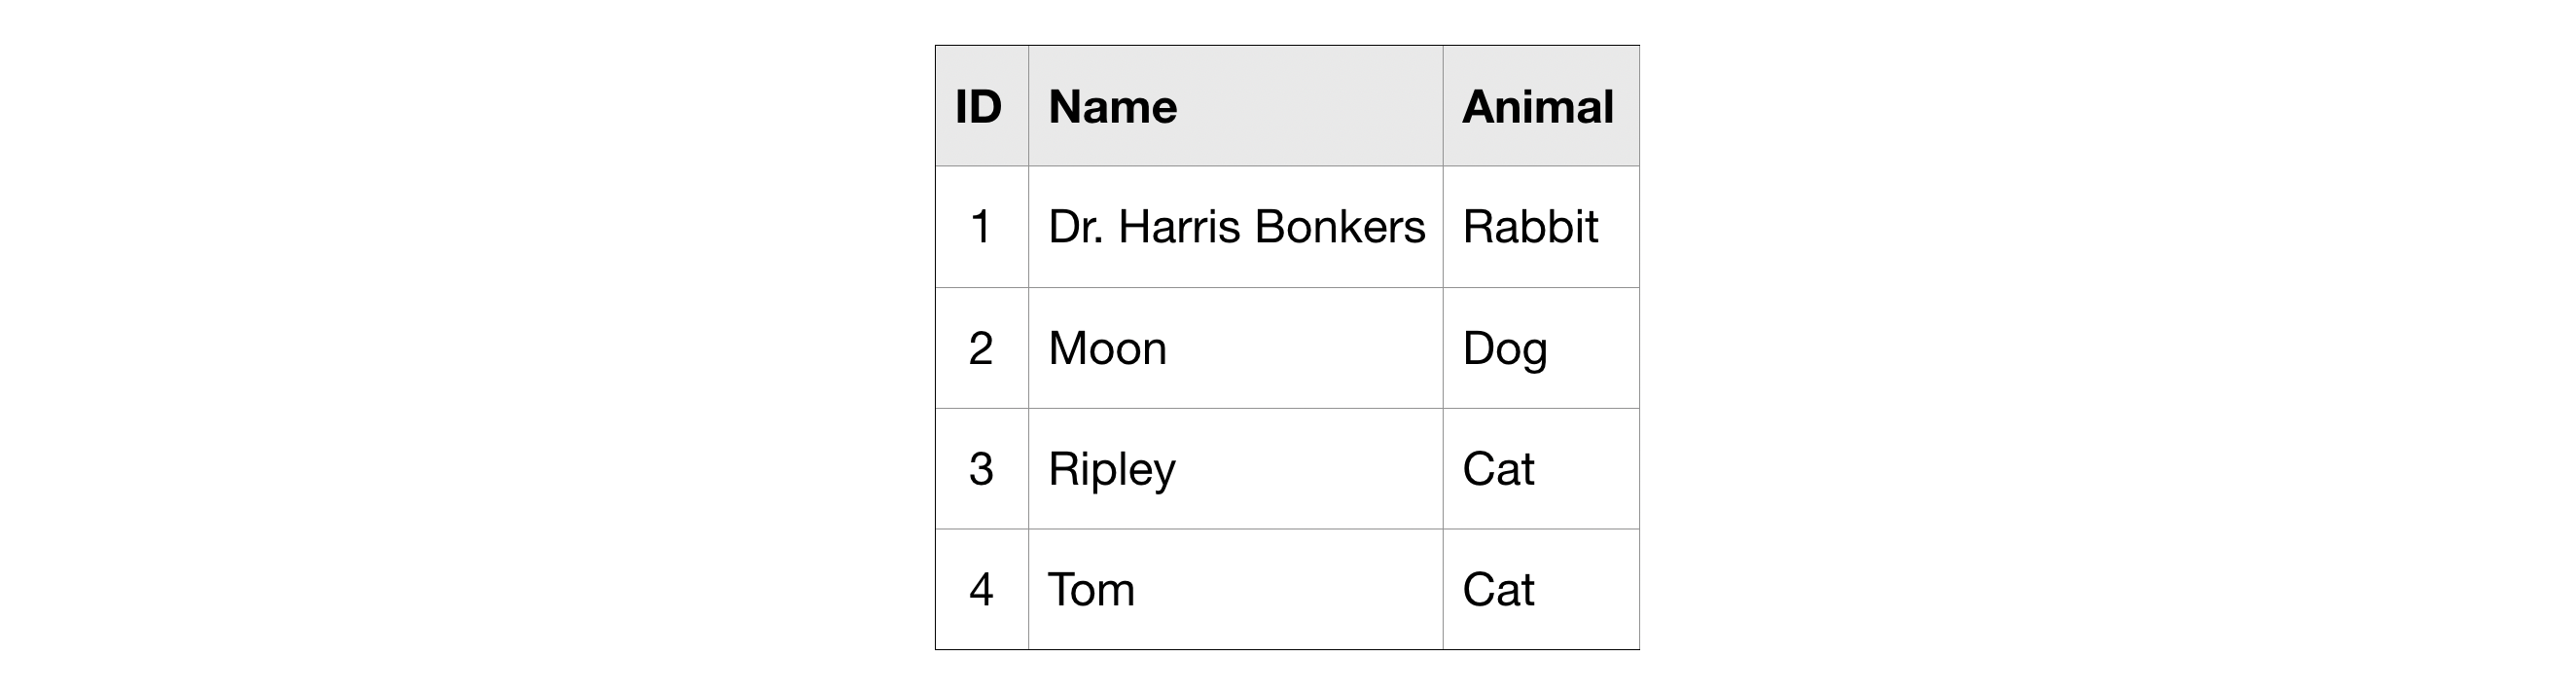

# COUNT()

---


COUNT(), como você deve ter adivinhado pelo nome, retorna uma contagem de coisas. Se você passar o nome de uma coluna, ele retornará o número de entradas nessa coluna.

Por exemplo, se selecionarmos o COUNT() da coluna ID na tabela pets, ele retornará 4, pois existem 4 IDs na tabela.

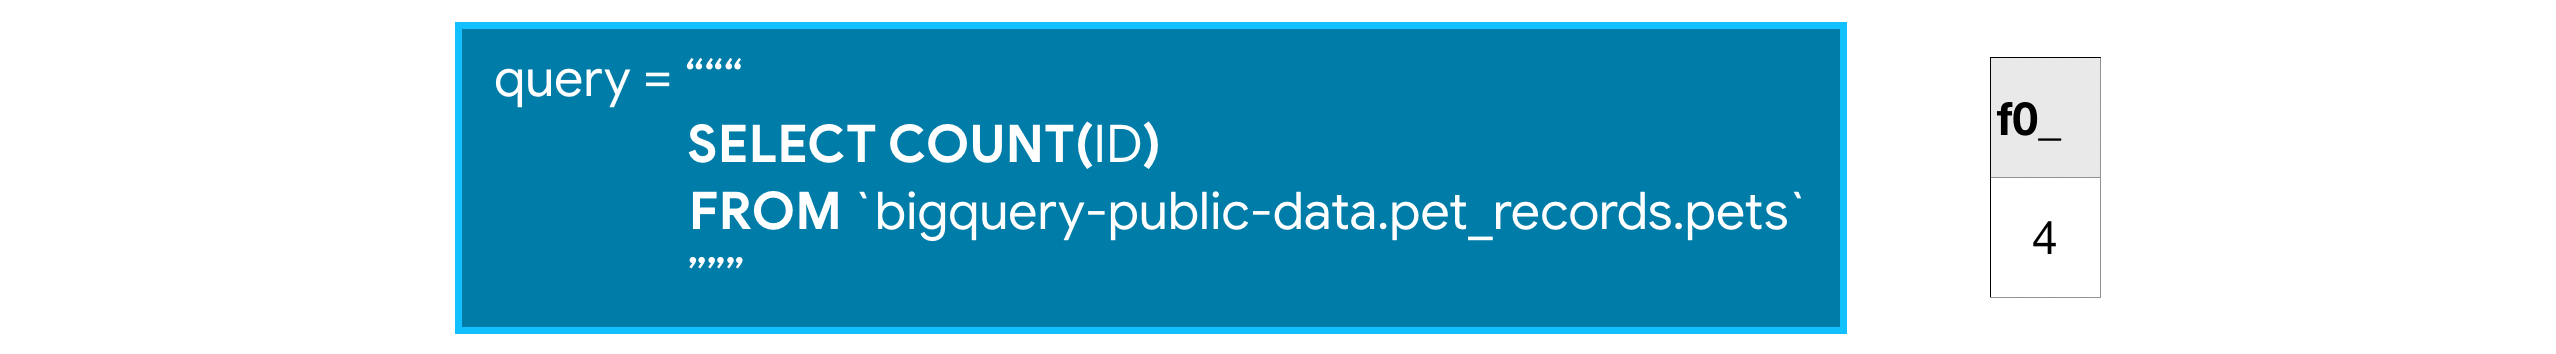

COUNT() é um exemplo de função agregada, que recebe muitos valores e retorna um. (Outros exemplos de funções agregadas incluem SUM(), AVG(), MIN() e MAX().) Como você notará na figura acima, as funções agregadas introduzem nomes de coluna estranhos (como f0__). Mais adiante neste tutorial, você aprenderá como alterar o nome para algo mais descritivo.

# GROUP BY

---


GROUP BY recebe o nome de uma ou mais colunas e trata todas as linhas com o mesmo valor nessa coluna como um único grupo quando você aplica funções agregadas como COUNT().

Por exemplo, digamos que queremos saber quantos de cada tipo de animal temos na tabela de animais de estimação. Podemos usar GROUP BY para agrupar linhas que tenham o mesmo valor na coluna Animal, enquanto usamos COUNT() para descobrir quantos IDs temos em cada grupo.

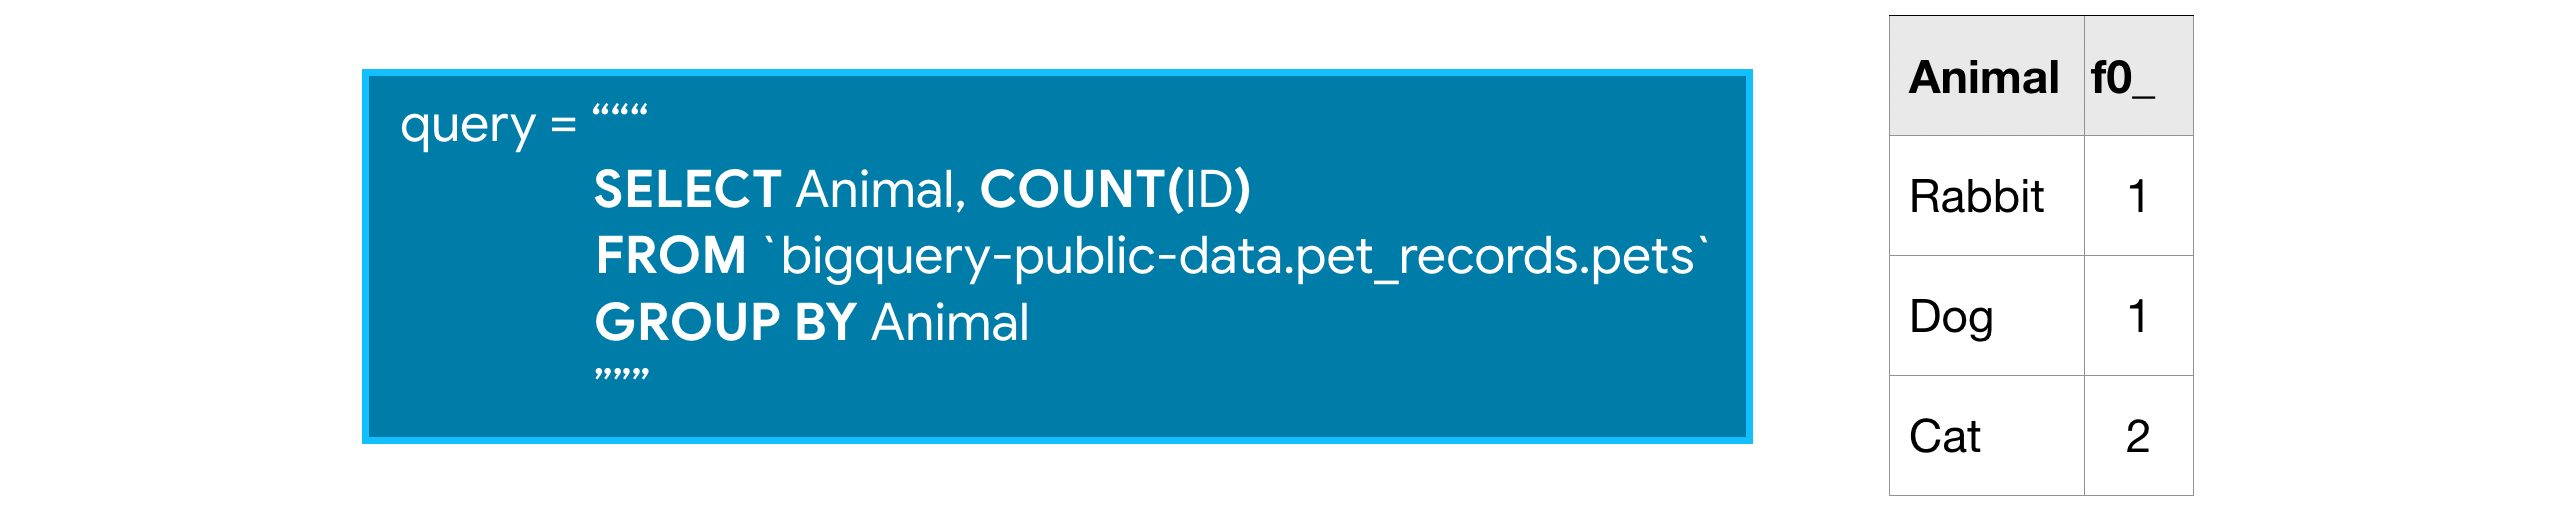

Ele retorna uma tabela com três linhas (uma para cada animal distinto). Podemos ver que a tabela de animais de estimação contém 1 coelho, 1 cachorro e 2 gatos

# GROUP BY ... HAVING

---


HAVING é usado em combinação com GROUP BY para ignorar grupos que não atendem a determinados critérios.

Portanto, esta consulta, por exemplo, incluirá apenas grupos que tenham mais de um ID neles.

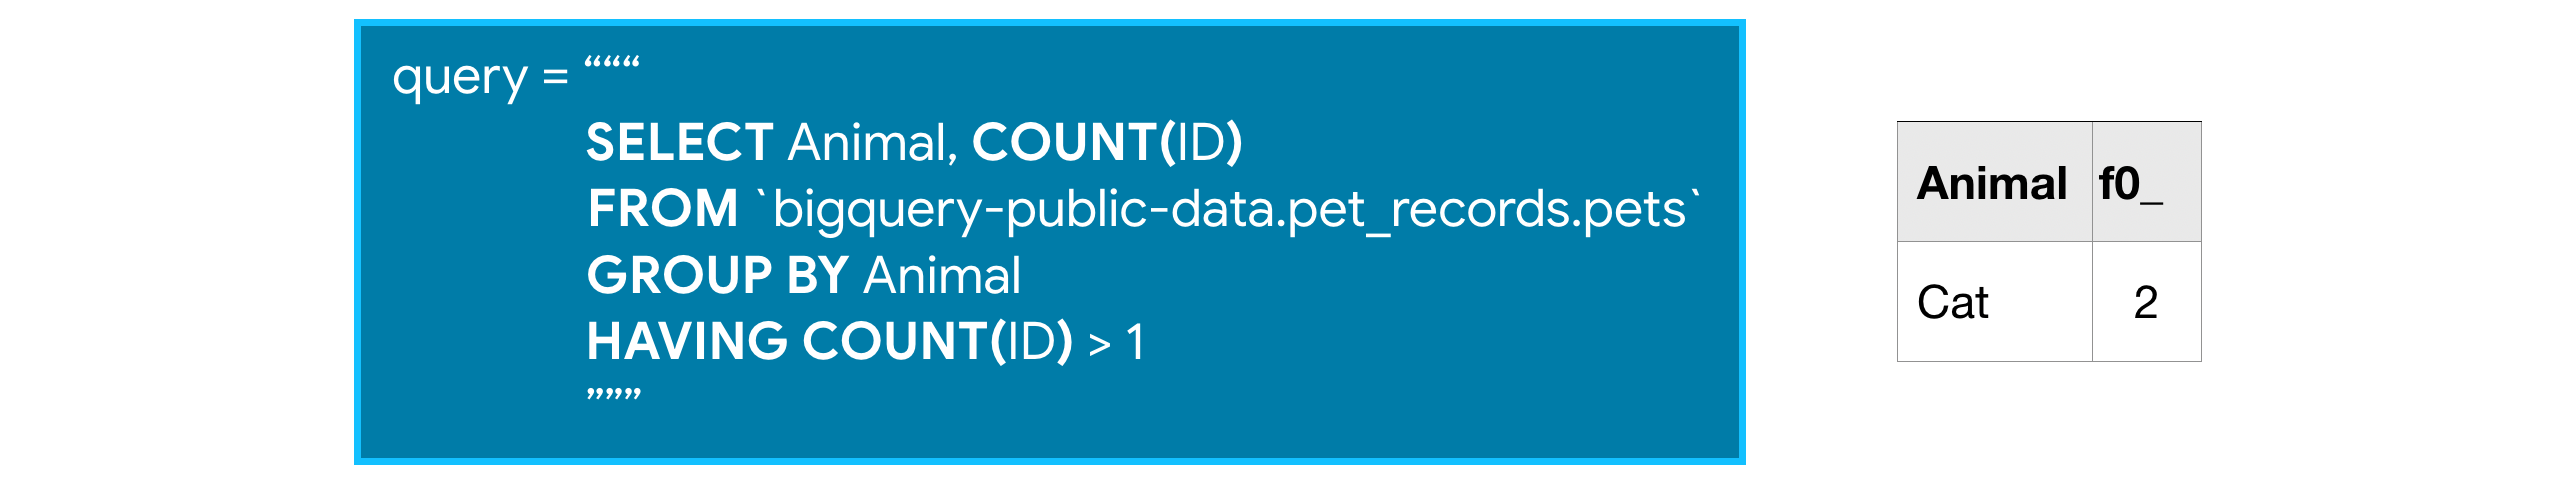

Como apenas um grupo atende ao critério especificado, a consulta retornará uma tabela com apenas uma linha.

## Exemplo: Quais comentários do Hacker News geraram mais discussão?

---


Pronto para ver um exemplo em um conjunto de dados real? O conjunto de dados Hacker News contém informações sobre histórias e comentários do site de rede social Hacker News.

Trabalharemos com a tabela de comentários e começaremos imprimindo as primeiras linhas. (Ocultamos o código correspondente. Para dar uma olhada, clique no botão "Código" abaixo.)

In [ ]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "comments" table
client.list_rows(table, max_results=5).to_dataframe()

Vamos usar a tabela para ver quais comentários geraram mais respostas. Desde:

* a coluna pai indica o comentário que foi respondido e
* a coluna id tem o ID exclusivo usado para identificar cada comentário,
podemos GROUP BY na coluna pai e COUNT() na coluna id para descobrir o número de comentários que foram feitos como respostas a um comentário específico. 

(Isso pode não fazer sentido imediatamente - reserve um tempo aqui para garantir que tudo esteja claro!)

Além disso, como estamos interessados apenas em comentários populares, analisaremos os comentários com mais de dez respostas. Assim, só retornaremos grupos TENDO mais de dez IDs.

In [ ]:
# Query to select comments that received more than 10 replies
query_popular = """
                SELECT parent, COUNT(id)
                FROM `bigquery-public-data.hacker_news.comments`
                GROUP BY parent
                HAVING COUNT(id) > 10
                """

Agora que nossa consulta está pronta, vamos executá-la e armazenar os resultados em um DataFrame pandas:

In [ ]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_popular, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
popular_comments = query_job.to_dataframe()

# Print the first five rows of the DataFrame
popular_comments.head()

Cada linha no DataFrame popular_comments corresponde a um comentário que recebeu mais de dez respostas. Por exemplo, o comentário com ID 801208 recebeu 56 respostas.

# Aliasing e outras melhorias
## Algumas dicas para tornar suas consultas ainda melhores:

A coluna resultante de COUNT(id) foi chamada f0__. Esse não é um nome muito descritivo. Você pode alterar o nome adicionando AS NumPosts depois de especificar a agregação. Isso é chamado de aliasing e será abordado com mais detalhes em uma próxima lição.
Se você não tiver certeza do que colocar dentro da função COUNT(), você pode fazer COUNT(1) para contar as linhas em cada grupo. A maioria das pessoas o acha especialmente legível, porque sabemos que não está focando em outras colunas. Ele também verifica menos dados do que os nomes de coluna fornecidos (tornando-o mais rápido e usando menos sua cota de acesso a dados).
Usando esses truques, podemos reescrever nossa consulta:

In [ ]:
# Improved version of earlier query, now with aliasing & improved readability
query_improved = """
                 SELECT parent, COUNT(1) AS NumPosts
                 FROM `bigquery-public-data.hacker_news.comments`
                 GROUP BY parent
                 HAVING COUNT(1) > 10
                 """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_improved, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
improved_df = query_job.to_dataframe()

# Print the first five rows of the DataFrame
improved_df.head()

Agora você tem os dados que deseja e tem nomes descritivos. Isso é bom estilo.

## Nota sobre o uso de GROUP BY
Observe que, como ele informa ao SQL como aplicar funções agregadas (como COUNT()), não faz sentido usar GROUP BY sem uma função agregada. Da mesma forma, se você tiver qualquer cláusula GROUP BY, todas as variáveis devem ser passadas para um

* comando GROUP BY ou
* uma função de agregação.

Considere a consulta abaixo:

In [ ]:
query_good = """
             SELECT parent, COUNT(id)
             FROM `bigquery-public-data.hacker_news.comments`
             GROUP BY parent
             """

Observe que existem duas variáveis: parent e id.

* parent foi passado para um comando GROUP BY (em GROUP BY parent), e
* id foi passado para uma função agregada (em COUNT(id)).

E esta consulta não funcionará, porque a coluna do autor não é passada para uma função agregada ou uma cláusula GROUP BY:

In [ ]:
query_bad = """
            SELECT author, parent, COUNT(id)
            FROM `bigquery-public-data.hacker_news.comments`
            GROUP BY parent
            """

Se cometer este erro, você receberá a mensagem de erro SELECT list expression reference column (column's name) que não está agrupada nem agregada em.